### Notes to do ###

1) Increase zone 4 distance from Goal line from 20 - 24 yards (Due to average mean position of players in first line of defence)
2) Clustering - to detect automatic formations i.e. starting positions of players when playing out the back- detect most common formations when playing out- atleast 3-5

In [ ]:
##########################################################################################
################  Importing Libraries #######################
import pandas as pd
import numpy as np
## Cell computation timer
#%load_ext autotime
from IPython.display import HTML
## Cell computation timer
%load_ext autotime
from scipy.spatial import distance
import jenkspy
import h5py
from speed_functions1 import * # -- seperate .py file 
import glob
import os

# || 2. Declare test data locations

H5=[]

A1=[]
A2=[]

Data_Loc = r'C:\Users\Home\Documents\Second Spectrum Everton Project\Short Goal Kicks Project\everton_tracking_data_h5'

for filename_with_ext in os.listdir(Data_Loc):
    
    if (filename_with_ext.endswith(".h5")):  
        
        # get the file name without the extension
        filename = filename_with_ext.split('.')[0]
        H5.append(filename)
H5=H5[:7]

for file in H5:
################  Importing H5 File ####################### 

    filename = r'C:\Users\Home\Documents\Second Spectrum Everton Project\Short Goal Kicks Project\everton_tracking_data_h5/'+str(file)+'.h5'

    key='final'
    df=pd.read_hdf(filename,key)
    df.Team_Name=df.Team_Name.fillna('BALL')
    df.name=df.Player_name.fillna('Ball')
    df.columns = df.columns.str.replace(' ', '')
    tracking=df
    tracking['Team_Name']=tracking['Team_Name'].astype(str)
    tracking.Team_Name=tracking.Team_Name.str.strip(' ')

    tracking['team1']=tracking['team'].astype(int)
    tracking.loc[tracking['team'] == '0', 'team'] = '2'
    tracking.loc[tracking['team'] == '0', 'name'] = 'Ball'
    tracking['team']=tracking['team'].astype(int)
    Away=tracking[tracking['team']==-1]
    Away=Away.Team_Name.unique()
    home=tracking[tracking['team']==1]
    home=home.Team_Name.unique()
    tracking['Possession']=np.where(tracking.lastTouch=='home',home,Away)
    tracking['gameClock1']=tracking['gameClock']/60
    tracking.loc[tracking['period'] == 2, 'gameClock1'] = tracking['gameClock1']+45
    tracking['gameClock2']=round(tracking['gameClock1'],2)
    
    ##########################################################################################

    ### Subsetting data for when team: Everton for animations ###
    Eve_team = 1
    ##########################################################################################
    ##bringing the scale with 108x65 coordinates
    # Players Tracking
    # margin of error after checking with video (x-axis)/ # margin of error after checking with video (y-axis)

    ##########################################################################################
    #tracking['x1']=tracking['x']+68
    #tracking['y1']=tracking['y']+40
    
    tracking['x']=np.where(tracking.period==2,tracking['x']*-1,tracking['x'])
    tracking['y']=np.where(tracking.period==2,tracking['y']*-1,tracking['y'])
    
    tracking['x1']=tracking['x']+52.5
    tracking['y1']=tracking['y']+34.5

    tracking['x1']=np.where(tracking['x1']<0,0,tracking['x1'])
    tracking['y1']=np.where(tracking['y1']<0,0,tracking['y1'])

    tracking=tracking.sort_values(['frameIdx','team'], ascending=[True,False])


    ##########################################################################################
    ############### The below functions add relative distance to ball, goals ################
    ##########################################################################################

    def add_ball_xy(tracking):

        ball_df = tracking[tracking['playerId'] == '00000'].reset_index(drop=True)[['frameIdx', 'x1', 'y1','z']]
        ball_df.columns = ['frameIdx', 'ball_x1', 'ball_y1','ball_z']

        tracking = tracking.merge(ball_df, on = "frameIdx")

        return(tracking)
    

    def add_distance_to_ball(tracking):

        if 'ball_x1' in tracking.columns:
            tracking['distance_to_ball'] = tracking[['x1', 'y1']].sub(np.array( tracking[['ball_x1', 'ball_y1']] )).pow(2).sum(1).pow(0.5)
            tracking.distance_to_ball = tracking.distance_to_ball.round(2)
            return(tracking)

        else:
            print("x||----------------")
            print("Ball x and y coordinates missing - 'add_distance_to_ball' function failed")
            print("Use 'add_ball_xy' to add the missing coordinates")
            print("----------------||x")

    def add_distance_to_goals(tracking, x = 60):

        tracking['distance_to_goal1'] = tracking[['x', 'y']].sub(np.array( [-x, 0] )).pow(2).sum(1).pow(0.5)
        tracking['distance_to_goal2'] = tracking[['x', 'y']].sub(np.array( [x, 0] )).pow(2).sum(1).pow(0.5)

        # trackingdata.distance_to_goal1 = trackingdata.distance_to_goal1.round(2)
        # trackingdata.distance_to_goal2 = trackingdata.distance_to_goal2.round(2)

        return(tracking)

    tracking=add_ball_xy(tracking)
    #tracking=add_ball_xy1(tracking)
    tracking=add_distance_to_ball(tracking)
    tracking=add_distance_to_goals(tracking)
    tracking = add_speed_classification(tracking)
    tracking.position = tracking.position.fillna('Ball')



    ##########################################################################################
    ###### Defining the ball handler for every frame ###########
    ############################################################################################

    tracking=tracking.sort_values(['frameIdx','distance_to_ball'], ascending=[True,True])
    tracking["rank"] = tracking.groupby("frameIdx")["distance_to_ball"].rank("dense", ascending=True)
    #Subsetting data for the closest player in every frame (Ball Handler)
    tracking=tracking.sort_values(['frameIdx','team'], ascending=[True,True])
    tracking['ball_handler']=np.where((tracking["rank"]==2.0) & (tracking.distance_to_ball<= 1) & (tracking.distance_to_ball> 0) & (tracking['live']==True) & (tracking['ball_z']<=0.35),tracking.Player_name,np.nan)
    tracking['ball_handler_number']=np.where((tracking["rank"]==2.0) & (tracking.distance_to_ball<= 1) & (tracking.distance_to_ball> 0) & (tracking['live']==True),tracking.number,0)
    tracking['ball_handler']=tracking['ball_handler'].fillna(method='ffill')
    tracking['ball_handler_position']=np.where((tracking["rank"]==2.0) & (tracking.distance_to_ball<= 1) & (tracking.distance_to_ball> 0) & (tracking['live']==True),tracking.position,np.nan)
    tracking['ball_handler_position']=tracking['ball_handler_position'].fillna(method='ffill')
    tracking['ball_handler_number']=tracking['ball_handler_number'].fillna(method='ffill')
    
    tracking['ball_handler1']=np.where((tracking["rank"]==2.0) & (tracking.distance_to_ball<= 0.5) & (tracking.distance_to_ball> 0) & (tracking['live']==True) & (tracking['ball_z']<=0.35),tracking.Player_name,np.nan)
    #tracking['ball_handler1']=np.where(tracking.distance_to_ball== 0, 'Ball',tracking['ball_handler1'])
    tracking['ball_handler1']=tracking['ball_handler1'].fillna('Ball')
    tracking['ball_handler']=np.where(tracking.distance_to_ball== 0, 'Ball',tracking['ball_handler'])
    tracking['ball_handler_team']=np.where((tracking["rank"]==2.0) & (tracking.distance_to_ball<= 1) & (tracking.distance_to_ball> 0),tracking.Team_Name,np.nan)
    tracking['ball_handler_team']=tracking['ball_handler_team'].fillna(method='ffill')
    tracking['ball_handler_team']=np.where(tracking.distance_to_ball== 0, 'Ball',tracking['ball_handler_team'])
    tracking['Team_Name1']=np.where((tracking['Team_Name']!='Everton') & (tracking['Team_Name']!='BALL'),'OPP',tracking['Team_Name'])
       
    ########################################################################################
    ######### Merging tracking and event data ##########

    track_events1=pd.read_csv(r'C:\Users\Home\Documents\Second Spectrum Everton Project\Short Goal Kicks Project\everton event data converted/'+str(file)+'.csv')
    #track_events1['Merger']=track_events1['Merger'].astype(str)
    #Shots=track_events1[track_events1['type_name']=='Shot'].reset_index(drop=True)
    #track_events1['Merger']=track_events1['Merger'].fillna(method='ffill')
    tracking.sort_values(['gameClock2'], inplace=True) 
    #tracking1=pd.merge(tracking,track_events1, on=['Merger'],how='left')
    trackingx=pd.merge(tracking,track_events1, left_on=['gameClock2'],right_on=['time'],how='left').reset_index(drop=True)
    
    ###### Looking for GKs ######

    ##### Subset the frameIds first #####
    frameIds_TO=trackingx[trackingx['play_pattern_name']=='From Goal Kick'][['frameIdx']].reset_index(drop=True).drop_duplicates(keep='first', inplace=False)
    frameIds_TO=frameIds_TO.sort_values(by='frameIdx',ascending=True)
    frameIds_TO_list=list(set(frameIds_TO.frameIdx))
    frameIds_TO_list.sort()

    turnover_sequence_id = 0
    gap_threshold=500
    turnover_sequence_id_list = [0]

    for turnover in range(1,len(frameIds_TO_list)):

            if (frameIds_TO_list[turnover] - frameIds_TO_list[turnover-1])<= gap_threshold:

                turnover_sequence_id_list.append(turnover_sequence_id)

            else:
                turnover_sequence_id = turnover_sequence_id + 1
                turnover_sequence_id_list.append(turnover_sequence_id)


    turnover_sequence_info = pd.DataFrame(
        {'frameIdx': frameIds_TO_list,
         'turnover_sequence_id': turnover_sequence_id_list
        })
    turnover_sequence_info.sort_values(by='frameIdx',ascending=True)


    start_of_seq = []
    end_of_seq = [] 

    unique_sequenceids = list(set(turnover_sequence_id_list))

    for uID in unique_sequenceids:

        temp = turnover_sequence_info[turnover_sequence_info['turnover_sequence_id'] == uID]

        start_of_seq.append(min(temp.frameIdx))
        end_of_seq.append(max(temp.frameIdx))

    GK_sequence_summary = pd.DataFrame(
        {'frameID_start': start_of_seq,
         'frameID_end': end_of_seq,
         'GK_sequence_id': unique_sequenceids
        })
    #### Starting atleast 16 seconds earlier ####
    GK_sequence_summary['frameID_start1']=GK_sequence_summary['frameID_start']-400
    ## 54548 -54948 long goal kick

    ####### Unzip the frames #######

    zipped = zip(GK_sequence_summary['GK_sequence_id'],GK_sequence_summary['frameID_start1'], GK_sequence_summary['frameID_start'])

    df = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                       columns=['GK_sequence_id','frameIdx'])
    sequence_summary_frames=df['frameIdx'].to_list()

    tracking1=tracking[(tracking['frameIdx'].isin(sequence_summary_frames))& (tracking['x']!=0) & (tracking['position']=='Ball')].reset_index(drop=True)[['frameIdx','x','y','y1','position']]
    tracking1=tracking1.sort_values(by='frameIdx',ascending=True)
    tracking1['difference']=tracking1['frameIdx']-tracking1['frameIdx'].shift(1)
    tracking2=tracking1[tracking1['difference']!=1].reset_index(drop=True)
    tracking3=pd.merge(tracking2,df,on='frameIdx',how='left')
    tracking3['frameID_end']=tracking3['frameIdx']+600
    ##### Filter out frameids when the ball is kicked and identify which side of the pitch they occur #####
    ### keep only following columns ###
    cols=['frameIdx','x','y','GK_sequence_id','frameID_end']

    tracking5=tracking3[cols]
    tracking5['side']=np.where(tracking5['x']<=-36,'Left','Right')
    trackingx1=tracking[(tracking['position']!='Ball') & (tracking['rank']==2.0)][['frameIdx','Team_Name']]
    trackingx1=trackingx1.drop_duplicates(keep='first', inplace=False)
    tracking5=pd.merge(tracking5,trackingx1,on='frameIdx',how='left')
    
    ### Subset for Everton Corners only ####
    
    tracking5=tracking5[tracking5['Team_Name']=='Everton'].reset_index(drop=True)
    
#    tracking5['Sequence']

    #### Unzip the accurate GK timings == 20 seconds per sequence ####

    zipped = zip(tracking5['GK_sequence_id'],tracking5['frameIdx'], tracking5['frameID_end'])

    df = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                       columns=['GK_sequence_id','frameIdx'])

    df=pd.merge(df,tracking5,on='GK_sequence_id',how='left').rename(columns={'frameIdx_x':'frameIdx'})
    final_sequence_summary_frames=df['frameIdx'].to_list()
    tracking=trackingx[trackingx['frameIdx'].isin(final_sequence_summary_frames)].reset_index(drop=True)
    tracking=tracking.drop(['ball_x1', 'ball_y1','ball_z'],axis=1)
    tracking1=pd.merge(tracking,df[['GK_sequence_id','frameIdx','side']],on='frameIdx',how='left')
    tracking1['x']= np.where(tracking1['side']=='Right',tracking1['x_x']*-1,tracking1['x_x'])
    tracking1['y']= np.where(tracking1['side']=='Right',tracking1['y_x']*-1,tracking1['y_x'])

    tracking1['x1']=tracking1['x']+52.5
    tracking1['y1']=tracking1['y']+34.5

    def add_ball_xy(tracking):

        ball_df = tracking[tracking['playerId'] == '00000'].reset_index(drop=True)[['frameIdx', 'x1', 'y1','z_x']]
        ball_df.columns = ['frameIdx', 'ball_x1', 'ball_y1','ball_z']

        tracking = pd.merge(tracking,ball_df, on = "frameIdx")

        return(tracking)
    
    tracking1=add_ball_xy(tracking1)
    
    

    bins = [-5,20,40,60,130]
    labels = ["H1","H2","H3","H4"]
    tracking1['H_zone']= pd.cut(tracking1['x1'], bins=bins, labels=labels)
    tracking1['ball_H_zone']= pd.cut(tracking1['ball_x1'], bins=bins, labels=labels)
    bins1 = [-5,13.84,54.16,75]
    labels1 = ["V1","V2","V3"]
    tracking1['V_zone']= pd.cut(tracking1['y1'], bins=bins1, labels=labels1)
    tracking1['ball_V_zone']= pd.cut(tracking1['ball_y1'], bins=bins1, labels=labels1)
    tracking1['zone_combo']=tracking1['V_zone'].astype(str)+tracking1['H_zone'].astype(str)
    tracking1['ball_zone_combo']=tracking1['ball_V_zone'].astype(str)+tracking1['ball_H_zone'].astype(str)

    col= 'zone_combo'
    conditions= [tracking1[col] == 'V3H1', tracking1[col] == 'V3H2', tracking1[col] == 'V3H3',
                tracking1[col] == 'V2H1',tracking1[col] == 'V2H2',tracking1[col] == 'V2H3',
                tracking1[col] == 'V1H1',tracking1[col] == 'V1H2',tracking1[col] == 'V1H3']
    choices= [1, 2,3,4,5,6,7,8,9]

    tracking1["zone_final"] = np.select(conditions, choices, default=10)
    
    col= 'ball_zone_combo'
    conditions= [tracking1[col] == 'V3H1', tracking1[col] == 'V3H2', tracking1[col] == 'V3H3',
                tracking1[col] == 'V2H1',tracking1[col] == 'V2H2',tracking1[col] == 'V2H3',
                tracking1[col] == 'V1H1',tracking1[col] == 'V1H2',tracking1[col] == 'V1H3']
    choices= [1, 2,3,4,5,6,7,8,9]
    
    
    tracking1["ball_zone_final"]=np.select(conditions, choices, default=10)
    #tracking1['ball_zone_final']=tracking1['ball_zone_final'].fillna(method='ffill')
    
    tracking1['match_id']=str(file)
    tracking5['match_id']=str(file)
    ##### Print the starting frames of each corner kick to evaluate the opposition ####

    tracking1['sequence']=tracking1['GK_sequence_id'].astype(str)+'-'+tracking1['match_id']
    tracking5['sequence']=tracking5['GK_sequence_id'].astype(str)+'-'+tracking5['match_id']
    
    ### subsetting the first frames to identify opposition set up ###
    #A3=A1[A1['sequence'].isin(Start_frames)].reset_index(drop=True)
    
    A1.append(tracking1)
    A2.append(tracking5)
    
    

C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [2]:
### Creating copies of the concatenated lists ###
A3=pd.concat(A1)
A4=pd.concat(A2)

### Using the original copy ###
A1=pd.concat(A1)
A2=pd.concat(A2)

time: 1min 55s


In [3]:
A2

frameIdx      x      y  GK_sequence_id  frameID_end   side Team_Name  \
0      17684 -47.40   2.91               0        18284   Left   Everton   
1      28455 -47.08   3.46               1        29055   Left   Everton   
2      54537 -46.93  -7.81               4        55137   Left   Everton   
3     108797 -47.23   8.85               8       109397   Left   Everton   
0      14301  45.61   0.97               2        14901  Right   Everton   
1      18142  45.43   0.40               3        18742  Right   Everton   
2      36898 -20.30   2.92               5        37498  Right   Everton   
3      44911  45.30   1.85               6        45511  Right   Everton   
4      50998  45.33   5.27               8        51598  Right   Everton   
5      55341  45.30   2.38               9        55941  Right   Everton   
6      58303  45.12   1.42              10        58903  Right   Everton   
7      78151  45.27   1.23              11        78751  Right   Everton   
8      80081  45.32   0.38              12        80681  Right   Everton   
9      84238  45.04   1.79              13        84838  Right   Everton   
10     86388  45.07  -2.23              14        86988  Right   Everton   
11    122853 -49.89 -33.16              16       123453   Left   Everton   
12    143046  45.08  -3.86              17       143646  Right   Everton   
0      55238  47.46   2.89               1        55838  Right   Everton   
1      56601  47.71   9.16               2        57201  Right   Everton   
2      59743  57.32 -17.84               3        60343  Right   Everton   
3      69688   9.03  14.51               5        70288  Right   Everton   
4     104343 -42.03  26.26               7       104943   Left   Everton   
5     140429 -35.04  13.29               9       141029  Right   Everton   
6     143057 -51.98 -33.47              10       143657   Left   Everton   
0      66545  45.25   3.73               3        67145  Right   Everton   
1      99262  45.04  -7.02               6        99862  Right   Everton   
2     111108  55.51 -17.48               8       111708  Right   Everton   
3     115623  46.11  -5.30               9       116223  Right   Everton   
4     117492  45.25  -4.95              10       118092  Right   Everton   
5     122071 -28.23 -34.10              11       122671  Right   Everton   
6     128956  45.38  -3.93              12       129556  Right   Everton   
0      18157  47.26  -8.87               1        18757  Right   Everton   
1      31436  46.90  -1.51               2        32036  Right   Everton   
2      47496  46.95   4.59               4        48096  Right   Everton   
3      67093  13.33   8.69               6        67693  Right   Everton   
4      82837  21.22  -2.94               8        83437  Right   Everton   
5      83029  23.86  -5.63               8        83629  Right   Everton   
6      88955  46.68  -8.67               9        89555  Right   Everton   
7      94673  46.79  -8.78              10        95273  Right   Everton   
8     103502  46.90  -3.42              12       104102  Right   Everton   
9     126532  50.32   6.07              13       127132  Right   Everton   
10    132907  41.73 -25.00              14       133507  Right   Everton   
11    133302  48.73  -6.19              14       133902  Right   Everton   
12    135918  49.61  -5.23              15       136518  Right   Everton   
13    149101  47.23   0.01              17       149701  Right   Everton   
0      17944  45.93  -0.82               1        18544  Right   Everton   
1      19567  45.66  -0.03               2        20167  Right   Everton   
2      42595  45.30   0.73               4        43195  Right   Everton   
3      67427  45.41   4.97               7        68027  Right   Everton   
4      75326  14.72  13.00               8        75926  Right   Everton   
5     119804  49.11  16.42              11       120404  Right   Everton   
6     133803  45.14  -1.24              12       134

time: 225 ms


### The below piece of code is to identify which zones are occupied in the first frame when the goal kick is taken

In [60]:
### Delete Duplicates from the summarized set of corners ###
A2['Seq']='Start'

### Indicate when the sequence starts ####

A5=A1.drop_duplicates(subset=['sequence','frameIdx','playerId'],keep='first', inplace=False)
frameIdxs=list(A2.frameIdx.unique())
A3=A5[A5['frameIdx'].isin(frameIdxs)].reset_index(drop=True)

## Is the ball in zone 4 and at least 1 player in zone 4 for away team ##
##### When the count is over 3 then start time is skewed,so adjust for abnormalities

Everton=A3[(A3['zone_final']==4) & (A3['ball_zone_final']==4) & (A3['Team_Name']=='Everton')].reset_index(drop=True)
Everton=Everton.groupby(['sequence','frameIdx'])['zone_final'].count()
Everton=pd.DataFrame(Everton)
Index=pd.DataFrame(Everton.index)
Index.columns=['Split']
Index[['sequence', 'frameIdx']]=Index.Split.apply(pd.Series)
Index=Index.drop(['Split'],axis=1)
Everton1=pd.merge(Index,Everton,on='sequence',how='left').reset_index(drop=True)
Everton1=Everton1.drop_duplicates(subset=['sequence'],keep='first', inplace=False)

col         = 'zone_final'
conditions  = [ Everton1[col] >= 6, Everton1[col] == 1, (Everton1[col] < 6) & (Everton1[col]>= 4),(Everton1[col] < 4) & (Everton1[col]> 1)]
choices     = [ "Outlier", 'Only 1' ,'3 or more','Upto 3']
Everton1['Zone 4 Everton Occupancy'] = np.select(conditions, choices, default=np.nan)
Everton1=Everton1.rename(columns={"zone_final": "Zone 4 Everton Player Count"})

#### Get the opposition name ####

OPP2=A3[(A3['Team_Name']!='Everton') & (A3['Team_Name']!='BALL')].reset_index(drop=True)
OPP2=OPP2[['sequence','frameIdx','Team_Name']]
OPP2=OPP2.drop_duplicates(subset=['sequence'],keep='first', inplace=False).reset_index(drop=True)
OPP2=OPP2.rename(columns={"Team_Name": "Opponent"})

## Is the ball in zone 4 and at least 1 player in zone 4 for away team ##

OPP=A3[(A3['zone_final']==4) & (A3['ball_zone_final']==4) & (A3['Team_Name']!='Everton') & (A3['Team_Name']!='BALL')].reset_index(drop=True)
OPP=pd.DataFrame(OPP.groupby(['sequence','frameIdx'])['zone_final'].count())
OPP=pd.DataFrame(OPP)
Index=pd.DataFrame(OPP.index)
Index.columns=['Split']
Index[['sequence', 'frameIdx']]=Index.Split.apply(pd.Series)
Index=Index.drop(['Split'],axis=1)
OPP1=pd.merge(Index,OPP,on='sequence',how='left').reset_index(drop=True)
OPP1=OPP1.rename(columns={"zone_final": "Zone 4 Opposition Player Count"})

##### Getting the chain of sequences involved until absorption ####

sequence_list=list(A1['sequence'].unique())

A=[]
B=[]
D=[]
E=[]
F=[]

for i in sequence_list:
    
    sequence_group=A1[A1['sequence']==i]
    sequence_group1=sequence_group.sort_values(['frameIdx'], ascending=[True])
    sequence_group1=sequence_group1[(sequence_group1['type_name']=='Ball Receipt*') & (sequence_group1['Team_Name']=='Everton')]
    Statsbomb_xG=list(sequence_group['statsbomb_xg'].unique())
    sequence_group4=list(sequence_group1.ball_handler_number.unique())
    sequence_group3=list(sequence_group['ball_zone_final'].unique())
    sequence_group2=list(sequence_group1['ball_zone_final'].unique())
    A.append(sequence_group3)
    B.append(i)
    D.append(sequence_group2)
    E.append(sequence_group4)
    F.append(Statsbomb_xG)
    
C=pd.DataFrame({'Chain':A,'sequence':B,'Zones':D,'Position':E,'Statsbomb_xG':F})

C['Zones1']=C['Zones'].astype(str).str[1:3]
C['GK_type']=np.where(C['Zones1']=='10','Played-Long','Played-Short')

#### Join the columns and check for nulls in other dataframes ####
### Assuming they have some common column, like name in your example, I'd do the following ###
Everton_Final = OPP2.merge(OPP1,on=['sequence','frameIdx'],how='left').merge(Everton1,on=['sequence','frameIdx'],how='left').fillna(0)
Everton_Final=Everton_Final.merge(C,on='sequence',how='left')
Everton_Final['Press Type']=np.where((Everton_Final['Zone 4 Opposition Player Count']>=2) & (Everton_Final['Zone 4 Everton Occupancy']!='Outlier'),'High-Block','Mid-Block')
Everton_Final

sequence  frameIdx       Opponent  Zone 4 Opposition Player Count  \
0    0-1059984     17684        Chelsea                             2.0   
1    1-1059984     28455        Chelsea                             0.0   
2    4-1059984     54537        Chelsea                             0.0   
3    8-1059984    108797        Chelsea                             0.0   
4    2-1059995     14301      Liverpool                             1.0   
5    3-1059995     18142      Liverpool                             1.0   
6    3-1059995     18142      Liverpool                             1.0   
7    5-1059995     36898      Liverpool                             0.0   
8    6-1059995     44911      Liverpool                             1.0   
9    8-1059995     50998      Liverpool                             0.0   
10   9-1059995     55341      Liverpool                             1.0   
11  10-1059995     58303      Liverpool                             1.0   
12  11-1059995     78151      Liverpool                             0.0   
13  12-1059995     80081      Liverpool                             1.0   
14  13-1059995     84238      Liverpool                             1.0   
15  14-1059995     86388      Liverpool                             0.0   
16  16-1059995    122853      Liverpool                             0.0   
17  17-1059995    143046      Liverpool                             0.0   
18   1-1060008     55238        Norwich                             2.0   
19   2-1060008     56601        Norwich                             2.0   
20   3-1060008     59743        Norwich                             5.0   
21   5-1060008     69688        Norwich                             0.0   
22   7-1060008    104343        Norwich                             0.0   
23   9-1060008    140429        Norwich                             0.0   
24  10-1060008    143057        Norwich                             0.0   
25   3-1060017     66545      Leicester                             0.0   
26   6-1060017     99262      Leicester                             2.0   
27   8-1060017    111108      Leicester                             1.0   
28   9-1060017    115623      Leicester                             0.0   
29  10-1060017    117492      Leicester                             0.0   
30  11-1060017    122071      Leicester                             0.0   
31  12-1060017    128956      Leicester                             0.0   
32   1-1060030     18157      Tottenham                             1.0   
33   2-1060030     31436      Tottenham                             1.0   
34   4-1060030     47496      Tottenham                             0.0   
35   6-1060030     67093      Tottenham                             0.0   
36   8-1060030     82837      Tottenham                             0.0   
37   9-1060030     88955      Tottenham                             0.0   
38  10-1060030     94673      Tottenham                             0.0   
39  12-1060030    103502      Tottenham                             0.0   
40  13-1060030    126532      Tottenham                             0.0   
41  14-1060030    132907      Tottenham                             0.0   
42  15-1060030    135918      Tottenham                             0.0   
43  17-1060030    149101      Tottenham                             0.0   
44   1-1060037     17944    Southampton                             1.0   
45   2-1060037     19567    Southampton                             1.0   
46   4-1060037     42595    Southampton                             1.0   
47   7-1060037     67427    Southampton                             0.0   
48   8-1060037     75326    Southampton                             0.0   
49  11-1060037    119804    Southampton                             1.0   
50  12-1060037    133803    Southampton                             0.0   
51   0-1060051     11052  Wolverhampton                             3.0   
52   1-1060051     18588  Wolve

time: 1min 52s


In [57]:
#### Pressure towards the ball is high when distance to ball < 6, Speed Class Segments: high_speed_running, Type_name: Pressure
sequence_group=A1[A1['sequence']=='0-1060051']
Pressure_speed_class=['high_speed_sprinting','high_speed_running']
sequence_group1=sequence_group[(sequence_group['type_name']=='Pressure') & (sequence_group['distance_to_ball']<=6) 
                               & (sequence_group['Team_Name']!='Everton') & (sequence_group['speed_class'].isin(Pressure_speed_class))
                              & (sequence_group['position']!='Ball')]
Num_of_plyrs_press=len(sequence_group1.position.unique())
Pos_player_pressure=sequence_group1.position.unique()


time: 699 ms


In [54]:
Pos_player_pressure

array(['GK'], dtype=object)

time: 4.07 ms


In [9]:
## Implementing clusters to cluster defense of opposition

lb_sequence_summary_frames=list(A2.frameIdx.unique())


b=[]
a=[]
e=[]
f=[]
g=[]
k=[]
l=[]
z=[]

for frame_select in lb_sequence_summary_frames:

    track_seg = A1[A1.frameIdx == frame_select]
    track_seg1=track_seg[(track_seg['Team_Name1'] == 'OPP') & (track_seg['position'] != 'GK')].reset_index()

    breaks = jenkspy.jenks_breaks(track_seg1['x1'], nb_class=3)

        
    track_seg1['Block']=pd.cut(track_seg1['x1'],
                              bins=breaks,
                             labels=['First_Line','Second_Line','Third_Line'],
                             include_lowest=True)
    
    #########################################
    #########################################


    b.append(breaks)
    a.append(frame_select)
    g.append(track_seg1)
    
    b1=pd.DataFrame(b).reset_index(drop=True)
    a1=pd.DataFrame(a).reset_index(drop=True)
    g1=pd.concat(g)
    c=pd.merge(a1, b1, left_index=True, right_index=True)
    c11=c.set_axis(['frameIdx','First_Line','Second_Line','Third_Line','Fourth_Line'], axis=1, inplace=False)
    c1=pd.merge(c11,A2,on='frameIdx',how='right')

time: 47 s


### The below code creates the animation of the sequence: ###

C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\mplsoccer\pitch.py:387: UserWarning: Pitch length and widths are only used for tracab pitches and will be ignored
  warnings.warn("Pitch length and widths are only used for tracab pitches and will be ignored")


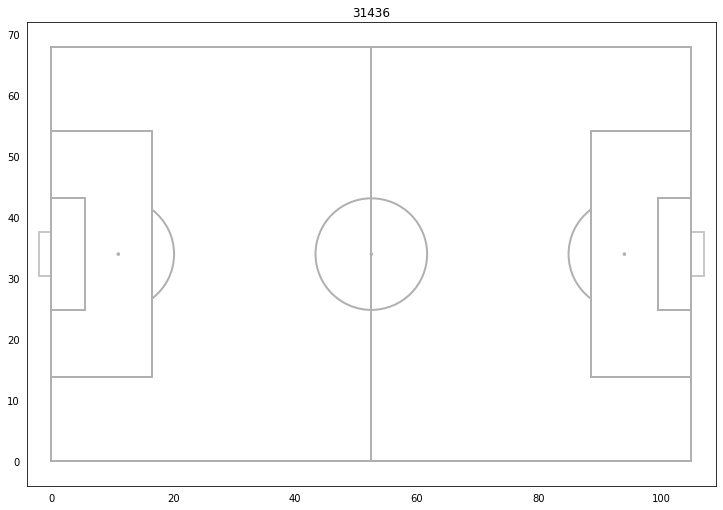

time: 2.46 s


In [78]:
B3=A1[A1['sequence']=='2-1060030']
start=31436
end=31437

flag_0 = flag_1 = True
t0_x = t0_y = t1_x = t1_y = pd.Series(dtype=float)

def animate_shot(starting_frame, ending_frame,Eve_team):
    ##### Animate the Section to Understand 
    from matplotlib import animation
    from mplsoccer.pitch import Pitch
    #%matplotlib widget
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt

    # Set up formatting for the movie files
    import matplotlib.animation as animation
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1
    
    frames_to_animate = list(range(starting_frame, ending_frame))

    pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1), figsize=(10.8, 7.2),
                  pitch_width=105,pitch_length=70,stripe=False,goal_type='box', axis=True, label=True)
    fig, ax = pitch.draw()
    

    ball, = ax.plot([], [], 'ko', ms=9,markerfacecolor='yellow')
    team_0, = ax.plot([], [], 'ko', ms=14,markerfacecolor='red',alpha=1)
    team_1, = ax.plot([], [], 'ko', ms=14,markerfacecolor='blue',alpha=1)


    
    # initialization function: plot the background of each frame
    def init():
        ball.set_data([], [])
        team_0.set_data([], [])
        team_1.set_data([], [])
        return ball, team_0, team_1
    
    annotations = []
    # arrows = []
    
    # animation function of dataframes' list

    
    def animate(i):
        ax.set_title(str(frames_to_animate[i]))
        
        
        global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1

        frame_ = B3[B3['frameIdx'] == frames_to_animate[i]]
                
        #Direction=frame_['Direction'].unique()
        ball_ = frame_[frame_['Team_Name'] == 'BALL'].reset_index()
        
        team0_ = frame_[(frame_['Team_Name'] != 'Everton') & (frame_['Team_Name'] != 'BALL')].reset_index()
        number0_ = frame_[(frame_['Team_Name'] != 'Everton') & (frame_['Team_Name'] != 'BALL')].reset_index()[['number']]
                
        team1_ = frame_[frame_['Team_Name'] == 'Everton'].reset_index()
        number1_ = frame_[frame_['Team_Name'] == 'Everton'].reset_index()[['number']]

        
        number0_.number = number0_.number.apply(lambda x: int(x))
        number1_.number = number1_.number.apply(lambda x: int(x))


        # set the ball data with the x and y positions for the ith frame
        ball.set_data(ball_.ball_x1, ball_.ball_y1)
        
        # set the player data using the frame id
        team_0.set_data(team0_.x1,team0_.y1)
        team_1.set_data(team1_.x1,team1_.y1)

        for i, a in enumerate(annotations):
            a.remove()
        annotations[:] = []
             # update for team 0
        for k in range(len(team0_)):
            try:
                annot1 = pitch.annotate(number0_.number[k], (team0_.x1[k], team0_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot1)

            except Exception as ex:
                pass
            t0_x = team0_.x1
            t0_y = team0_.y1

        # update for team 1
        for k in range(len(team1_)):
            try:
                annot2 = pitch.annotate(number1_.number[k], (team1_.x1[k], team1_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot2)

            except Exception as ex:
                pass
            t1_x = team1_.x1
            t1_y = team1_.y1


        ax.margins(x=0, y=-0.25) 
        
        return ball, team_0, team_1
    
    # call the animator, animate every 300 msx`
    # note that its hard to get the ffmpeg requirements right. I installed from conda-forge: see the conda.yml file
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_animate), init_func=init, interval=25, blit=False)
    return(anim)

#anim.save(r"C:\Users\Home\Documents\mwe.mov")
anim = animate_shot(start,end,1).to_html5_video()


HTML(anim)


In [154]:
def my_kde(data, width=1, gridsize=100, normalized=True, bounds=None):
    """
    Compute the gaussian KDE from the given sample.

    Args:
        data (array or list): sample of values
        width (float): width of the normal functions
        gridsize (int): number of grid points on which the kde is computed
        normalized (bool): if True the KDE is normalized (default)
        bounds (tuple): min and max value of the kde

    Returns:
        The grid and the KDE
    """
    # boundaries
    if bounds:
        xmin, xmax = bounds
    else:
        xmin = min(data) - 3 * width
        xmax = max(data) + 3 * width

    # grid points
    x = np.linspace(xmin, xmax, gridsize)

    # compute kde
    kde = np.zeros(gridsize)
    for val in data:
        kde += norm.pdf(x, loc=val, scale=width)

    # normalized the KDE
    if normalized:
        kde /= sp.integrate.simps(kde, x)

    return x, kde

time: 10.5 ms


In [158]:
data=list(B3.x1.unique())
len(data)

5796

time: 18.9 ms


In [24]:
mask = (B3['frameIdx'] >= 17684) & (B3['frameIdx'] <= 17877)
df1 = B3.loc[mask]

df1.to_csv(r'C:\Users\Home\Documents\C.csv')

time: 352 ms


In [ ]:
check=A1.head(5)
check.to_csv(r'C:\Users\Home\Documents\D.csv')

In [ ]:
C.to_csv(r'C:\Users\Home\Documents\D.csv')

In [ ]:
##### Print the starting frames of each corner kick to evaluate the opposition ####

A1['sequence']=A1['frameIdx'].astype(str)+'-'+A1['match_id']
A2['sequence']=A2['frameIdx'].astype(str)+'-'+A2['match_id']
Start_frames=list(A2['sequence'].unique())

### subsetting the first frames to identify opposition set up ###
A3=A1[A1['sequence'].isin(Start_frames)].reset_index(drop=True)

In [ ]:
tracking.period_x.unique()

In [ ]:
### Understanding the mean average position of the GK ###
Pos_1st_Everton=tracking[(tracking.Team_Name=='Everton') & (tracking.period_x==1) & (tracking.position=='GK')][['x_x']].mean()
#Pos_1st_Opp=tracking[(tracking.Team_Name!='Everton') & (tracking.Team_Name!='BALL') & (tracking.period_x==1) & (tracking.position=='GK')][['x_x']].mean()
Pos_2nd_Everton=tracking[(tracking.Team_Name=='Everton') & (tracking.period_x==2) & (tracking.position=='GK')][['x_x']].mean()
#Pos_2nd_Opp=tracking[(tracking.Team_Name!='Everton') & (tracking.Team_Name!='BALL')& (tracking.period_x==2) & (tracking.position=='GK')][['x_x']].mean()
print('Pos_1st_Everton'+str(Pos_1st_Everton))
#print('Pos_1st_Opp'+str(Pos_1st_Opp))
print('Pos_2nd_Everton'+str(Pos_2nd_Everton))
#print('Pos_2nd_Opp'+str(Pos_2nd_Opp))




In [ ]:
tracking5['side']=np.where(tracking5['x']<=-36,'Left','Right')
trackingx1=tracking[(tracking['position']!='Ball') & (tracking['rank']==2.0)][['frameIdx','Team_Name']]
trackingx1=trackingx1.drop_duplicates(keep='first', inplace=False)
tracking5=pd.merge(tracking5,trackingx1,on='frameIdx',how='left')

In [ ]:
check3['frameIdx_sequence']=check3['frameIdx'].astype(str)+'-'+check3['GK_sequence_id_x'].astype(str)
sequence_list1=list(check3.frameIdx_sequence.unique())

In [ ]:
from mplsoccer.pitch import Pitch
#%matplotlib widget
import matplotlib.patches as patches
import matplotlib.pyplot as plt


for k in sequence_list1:


    ## test line break with back_line 
    #playa = A3.iloc[k]['player_id']
    #fra = A3.iloc[k]['sequence']

    frame___ = check3[(check3['frameIdx_sequence'] == k)].reset_index(drop=True)
    #p_fra = frame___[frame___['player_id'] == playa].reset_index(drop=True)
    
    b_fra = frame___[frame___['Team_Name_x'] == 'BALL'].reset_index(drop=True)
    
    t_fra = frame___[frame___['Team_Name_x'] == 'Everton'].reset_index(drop=True)
    o_fra = frame___[(frame___['Team_Name_x'] != 'Everton') & (frame___['Team_Name_x'] != 'BALL')].reset_index(drop=True)
    o_fra=o_fra.sort_values(by='y1')
    First_Line=o_fra[o_fra['Block']=='First_Line'].reset_index(drop=True)
    Second_Line=o_fra[o_fra['Block']=='Second_Line'].reset_index(drop=True)
    Third_Line=o_fra[o_fra['Block']=='Third_Line'].reset_index(drop=True)
    
    # print(o_fra)
    pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
        pitch_width=68,pitch_length=105,stripe=False,goal_type='line',axis=False,label=True)
    fig, ax = pitch.draw()


    #ax.plot(p_fra.x1, p_fra.y1, 'ko', ms=14,markerfacecolor='blue', zorder=2) #red/maroon
    

    ax.plot(t_fra.x1, t_fra.y1, 'ko', ms=12,markerfacecolor='blue', zorder=2,alpha=0.8) #red/maroon
    #ax.plot(o_fra.x1, o_fra.y1, 'ko', ms=12,markerfacecolor='red', zorder=1,alpha=0.8) #red/maroon
    ax.plot(b_fra.ball_x1, b_fra.ball_y1, 'ko', ms=6,markerfacecolor='white', zorder=4) #red/maroon

    #ax.plot(First_Line.x1,First_Line.y1, color = "red",zorder=3,alpha=0.2)
    #ax.plot(Second_Line.x1,Second_Line.y1, color = "red",zorder=3,alpha=0.2)
    #ax.plot(Third_Line.x1,Third_Line.y1, color = "red",zorder=3,alpha=0.2)
    
    plt.title(str(frame___.sequence_x.unique()))
    
    plt.savefig(r'C:\Users\Home\Documents\Second Spectrum Everton Project\Short Goal Kicks Project\Tracking Opposition Formation\Everton Formation/'+'image'+str(k)+'.png')
    
    #plt.show()


    # print(p_fra)
    # print(o_fra)

In [ ]:
frame___.First_Line[0]

In [ ]:
import cv2
import os

image_folder = r'C:\Users\Home\Documents\Second Spectrum Everton Project\Short Goal Kicks Project\Tracking Opposition Formation'
video_name = r'C:\Users\Home\Documents\Second Spectrum Everton Project\Short Goal Kicks Project\Tracking Opposition Formation/video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [ ]:
###### Looking for GKs ######

##### Subset the frameIds first #####
frameIds_TO=trackingx[trackingx['play_pattern_name']=='From Goal Kick'][['frameIdx']].reset_index(drop=True).drop_duplicates(keep='first', inplace=False)
frameIds_TO=frameIds_TO.sort_values(by='frameIdx',ascending=True)
frameIds_TO_list=list(set(frameIds_TO.frameIdx))
frameIds_TO_list.sort()

turnover_sequence_id = 0
gap_threshold=500
turnover_sequence_id_list = [0]

for turnover in range(1,len(frameIds_TO_list)):

        if (frameIds_TO_list[turnover] - frameIds_TO_list[turnover-1])<= gap_threshold:

            turnover_sequence_id_list.append(turnover_sequence_id)

        else:
            turnover_sequence_id = turnover_sequence_id + 1
            turnover_sequence_id_list.append(turnover_sequence_id)


turnover_sequence_info = pd.DataFrame(
    {'frameIdx': frameIds_TO_list,
     'turnover_sequence_id': turnover_sequence_id_list
    })
turnover_sequence_info.sort_values(by='frameIdx',ascending=True)


start_of_seq = []
end_of_seq = [] 

unique_sequenceids = list(set(turnover_sequence_id_list))

for uID in unique_sequenceids:

    temp = turnover_sequence_info[turnover_sequence_info['turnover_sequence_id'] == uID]

    start_of_seq.append(min(temp.frameIdx))
    end_of_seq.append(max(temp.frameIdx))

GK_sequence_summary = pd.DataFrame(
    {'frameID_start': start_of_seq,
     'frameID_end': end_of_seq,
     'GK_sequence_id': unique_sequenceids
    })
#### Starting atleast 12 seconds earlier ####
GK_sequence_summary['frameID_start1']=GK_sequence_summary['frameID_start']-300
## 54548 -54948 long goal kick

####### Unzip the frames #######

zipped = zip(GK_sequence_summary['GK_sequence_id'],GK_sequence_summary['frameID_start1'], GK_sequence_summary['frameID_start'])

df = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                   columns=['GK_sequence_id','frameIdx'])
sequence_summary_frames=df['frameIdx'].to_list()

tracking1=tracking[(tracking['frameIdx'].isin(sequence_summary_frames))& (tracking['x']!=0) & (tracking['position']=='Ball')].reset_index(drop=True)[['frameIdx','x','y','y1','position','ball_handler_position']]
tracking1=tracking1.sort_values(by='frameIdx',ascending=True)
tracking1['difference']=tracking1['frameIdx']-tracking1['frameIdx'].shift(1)
tracking2=tracking1[tracking1['difference']!=1].reset_index(drop=True)
tracking3=pd.merge(tracking2,df,on='frameIdx',how='left')
tracking3['frameID_end']=tracking3['frameIdx']+500
##### Filter out frameids when the ball is kicked and identify which side of the pitch they occur #####
### keep only following columns ###
cols=['frameIdx','x','y','GK_sequence_id','frameID_end']

tracking5=tracking3[cols]
tracking5['side']=np.where(tracking5['x']<=-36,'Left','Right')

#### Unzip the accurate GK timings == 20 seconds per sequence ####

zipped = zip(tracking5['GK_sequence_id'],tracking5['frameIdx'], tracking5['frameID_end'])

df = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                   columns=['GK_sequence_id','frameIdx'])

df=pd.merge(df,tracking5,on='GK_sequence_id',how='left').rename(columns={'frameIdx_x':'frameIdx'})
final_sequence_summary_frames=df['frameIdx'].to_list()
Final=trackingx[trackingx['frameIdx'].isin(final_sequence_summary_frames)].reset_index(drop=True)
Final1=pd.merge(Final,df,on='frameIdx',how='left')
Final1['x']= np.where(Final1['side']=='Right',Final1['x']*-1,Final1['x'])
Final1['y']= np.where(Final1['side']=='Right',Final1['y']*-1,Final1['y'])

def add_ball_xy(tracking):

    ball_df = tracking[tracking['playerId'] == 0].reset_index(drop=True)[['frameIdx', 'x', 'y','z']]
    ball_df.columns = ['frameIdx', 'ball_x', 'ball_y','ball_z']

    tracking = pd.merge(tracking,ball_df, on = "frameIdx")

    return(tracking)

Final1=add_ball_xy(Final1)


In [ ]:
####### Unzip the frames #######

zipped = zip(GK_sequence_summary['GK_sequence_id'],GK_sequence_summary['frameID_start1'], GK_sequence_summary['frameID_start'])

df = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                   columns=['GK_sequence_id','frameIdx'])
sequence_summary_frames=df['frameIdx'].to_list()

tracking1=tracking[(tracking['frameIdx'].isin(sequence_summary_frames))& (tracking['x']!=0) & (tracking['position']=='Ball')].reset_index(drop=True)[['frameIdx','x','y','y1','position','ball_handler_position']]
tracking1=tracking1.sort_values(by='frameIdx',ascending=True)
tracking1['difference']=tracking1['frameIdx']-tracking1['frameIdx'].shift(1)
tracking2=tracking1[tracking1['difference']!=1].reset_index(drop=True)
tracking3=pd.merge(tracking2,df,on='frameIdx',how='left')
tracking3['frameID_end']=tracking3['frameIdx']+500
##### Filter out frameids when the ball is kicked and identify which side of the pitch they occur #####
### keep only following columns ###
cols=['frameIdx','x','y','GK_sequence_id','frameID_end']

tracking5=tracking3[cols]
tracking5['frameID_end']=tracking5['frameID_end']+100
tracking5['side']=np.where(tracking5['x']<=-36,'Left','Right')

#### Unzip the accurate GK timings == 20 seconds per sequence ####

zipped = zip(tracking5['GK_sequence_id'],tracking5['frameIdx'], tracking5['frameID_end'])

df = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                   columns=['GK_sequence_id','frameIdx'])

df=pd.merge(df,tracking5,on='GK_sequence_id',how='left').rename(columns={'frameIdx_x':'frameIdx'})
final_sequence_summary_frames=df['frameIdx'].to_list()
Final=trackingx[trackingx['frameIdx'].isin(final_sequence_summary_frames)].reset_index(drop=True)
Final1=pd.merge(Final,df,on='frameIdx',how='left')
Final1['x']= np.where(Final1['side']=='Right',Final1['x']*-1,Final1['x'])
Final1['y']= np.where(Final1['side']=='Right',Final1['y']*-1,Final1['y'])

def add_ball_xy(tracking):

    ball_df = tracking[tracking['playerId'] == 0].reset_index(drop=True)[['frameIdx', 'x', 'y','z']]
    ball_df.columns = ['frameIdx', 'ball_x', 'ball_y','ball_z']

    tracking = pd.merge(tracking,ball_df, on = "frameIdx")

    return(tracking)

Final1=add_ball_xy(Final1)


In [ ]:
tracking=tracking[tracking['frameIdx'].isin(final_sequence_summary_frames)].reset_index(drop=True)
tracking=tracking.drop(['ball_x1', 'ball_y1','ball_z'],axis=1)
tracking1=pd.merge(tracking,df[['GK_sequence_id','frameIdx','side']],on='frameIdx',how='left')
tracking1['x']= np.where(tracking1['side']=='Right',tracking1['x']*-1,tracking1['x'])
tracking1['y']= np.where(tracking1['side']=='Right',tracking1['y']*-1,tracking1['y'])

tracking['x1']=tracking1['x']+52.5
tracking['y1']=tracking1['y']+34.5

def add_ball_xy(tracking):

    ball_df = tracking[tracking['playerId'] == '00000'].reset_index(drop=True)[['frameIdx', 'x1', 'y1','z']]
    ball_df.columns = ['frameIdx', 'ball_x1', 'ball_y1','ball_z']

    tracking = pd.merge(tracking,ball_df, on = "frameIdx")

    return(tracking)

tracking1=add_ball_xy(tracking1)

In [ ]:
mask = (B3['frameIdx'] >= 44911) & (B3['frameIdx'] <= 45211)
df1 = B3.loc[mask]

df1.to_csv(r'C:\Users\Home\Documents\df2.csv')

In [ ]:
df1.match_id.unique()

In [ ]:
trackingx.head(5).to_csv(r'C:\Users\Home\Documents\df2.csv')

In [ ]:
flag_0 = flag_1 = True
t0_x = t0_y = t1_x = t1_y = pd.Series(dtype=float)

def animate_shot(starting_frame, ending_frame,Eve_team):
    ##### Animate the Section to Understand 
    from matplotlib import animation
    from mplsoccer.pitch import Pitch
    #%matplotlib widget
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt

    # Set up formatting for the movie files
    import matplotlib.animation as animation
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1
    
    frames_to_animate = list(range(starting_frame, ending_frame))

    pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1), figsize=(10.8, 7.2),
                  pitch_width=105,pitch_length=70,stripe=False,goal_type='box', axis=False, label=False)
    fig, ax = pitch.draw()
    

    ball, = ax.plot([], [], 'ko', ms=9,markerfacecolor='yellow')
    team_0, = ax.plot([], [], 'ko', ms=14,markerfacecolor='red',alpha=1)
    team_1, = ax.plot([], [], 'ko', ms=14,markerfacecolor='blue',alpha=1)


    
    # initialization function: plot the background of each frame
    def init():
        ball.set_data([], [])
        team_0.set_data([], [])
        team_1.set_data([], [])
        return ball, team_0, team_1
    
    annotations = []
    # arrows = []
    
    # animation function of dataframes' list

    
    def animate(i):
        ax.set_title(str(frames_to_animate[i]))
        
        
        global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1

        frame_ = check[check['frameIdx'] == frames_to_animate[i]]
                
        #Direction=frame_['Direction'].unique()
        ball_ = frame_[frame_['Team_Name'] == 'BALL'].reset_index()
        
        team0_ = frame_[(frame_['Team_Name'] != 'Everton') & (frame_['Team_Name'] != 'BALL')].reset_index()
        number0_ = frame_[(frame_['Team_Name'] != 'Everton') & (frame_['Team_Name'] != 'BALL')].reset_index()[['number']]
                
        team1_ = frame_[frame_['Team_Name'] == 'Everton'].reset_index()
        number1_ = frame_[frame_['Team_Name'] == 'Everton'].reset_index()[['number']]

        
        number0_.number = number0_.number.apply(lambda x: int(x))
        number1_.number = number1_.number.apply(lambda x: int(x))


        # set the ball data with the x and y positions for the ith frame
        ball.set_data(ball_.ball_x2, ball_.ball_y2)
        
        # set the player data using the frame id
        team_0.set_data(team0_.x2,team0_.y2)
        team_1.set_data(team1_.x2,team1_.y2)

        for i, a in enumerate(annotations):
            a.remove()
        annotations[:] = []
             # update for team 0
        for k in range(len(team0_)):
            try:
                annot1 = pitch.annotate(number0_.number[k], (team0_.x2[k], team0_.y2[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot1)

            except Exception as ex:
                pass
            t0_x = team0_.x2
            t0_y = team0_.y2

        # update for team 1
        for k in range(len(team1_)):
            try:
                annot2 = pitch.annotate(number1_.number[k], (team1_.x2[k], team1_.y2[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot2)

            except Exception as ex:
                pass
            t1_x = team1_.x2
            t1_y = team1_.y2


        
        #ax.set_xlim(-4,124)
        #ax.set_ylim(-4,84)
        #ax.axvline(x=def_line_x,alpha=0.6,color="beige")
        #plt.quiver(team0_['x2'], team0_['y2'].shift(-1), team0_['next_x2'], team0_['next_y2'].shift(-1), zorder=0.7, pivot="tail" ) 
        #ax.axvline(x=70,alpha=0.1,color="beige")
        #ax.axvline(x=35,alpha=0.1,color="beige")
        #ax.axvline(x=105,alpha=0.1,color="beige")
        #ax.axhline(y=54,alpha=0.1,color="beige")
        #ax.axhline(y=68,alpha=0.1,color="beige")
        #ax.invert_xaxis()
        #ax.invert_yaxis()
        ax.margins(x=0, y=-0.25) 
        
        return ball, team_0, team_1
    
    # call the animator, animate every 300 msx`
    # note that its hard to get the ffmpeg requirements right. I installed from conda-forge: see the conda.yml file
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_animate), init_func=init, interval=25, blit=False)
    return(anim)

#anim.save(r"C:\Users\Home\Documents\mwe.mov")
anim = animate_shot(17747,18247,1).to_html5_video()


HTML(anim)
